In [39]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-g9d5nyq6
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-g9d5nyq6
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0382a1f98892c95ad026d3ae50e3bdb64820bb3f8_-cp36-none-any.whl size=101463 sha256=5153e9674f801d8b3e946569b2b04ab502f616a5285daf7d3d543ccd7d5cc95d
  Stored in directory: /tmp/pip-ephem-wheel-cache-h33_i7xb/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [53]:
import pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def read_pickle_data_file(file_path):
  """
  Used To read pickle files that contain countries features as dictionaries.

  Parameters:
  file_path (string): The path of the file that contain country feature

  Returns:
  dictionary: Country feature as a dictionary
  """
  
  with open(file_path, 'rb') as handle:
    return pickle.load(handle)

In [0]:
def prune_dictionary(common_dicts_keys, pruning_dict):
  """
  Used To remove from a dictionary the keys that are uncommon in the countries features dictionaries.

  Parameters:
  common_dicts_keys (set): Set contains the common keys in the countries features dictionaries
  pruning_dict (dictionary): The dictionary to be prune
  """

  for key in list(pruning_dict.keys()): 
    if key not in common_dicts_keys:
        del pruning_dict[key]

# **Loading Countries Features**

Each country owns a **COVID-19 total cases** until 15/5/2020 "which is the target of our problem" and a vector that contains the following features:

*   Population
*   Humidity
*   Sun hours
*   Average tempreture
*   Gross Domestic Product (GDP)
*   COVID-19 total deaths until 15/5/2020
*   COVID-19 total tests until 15/5/2020
*   Spanish flu total deaths (2009)
*   Spanish flu total cases (2009)





In [0]:
OWID_PATH = 'drive/My Drive/COVID-19/our-world-in-data/country-features'
WEATHER_FEATURES_PATH = 'drive/My Drive/COVID-19/weather-features/country-features'
COUNTRY_DATA_PATH = 'drive/My Drive/COVID-19/country-data'

In [0]:
total_cases_dict = read_pickle_data_file(OWID_PATH + '/total_cases_dict.pickle')
population_dict = read_pickle_data_file(OWID_PATH + '/population_dict.pickle')
humidity_dict = read_pickle_data_file(WEATHER_FEATURES_PATH + '/humidity_dict.pickle')
sun_hour_dict = read_pickle_data_file(WEATHER_FEATURES_PATH + '/sunHour_dict.pickle')
tempreture_dict = read_pickle_data_file(WEATHER_FEATURES_PATH + '/tempC_dict.pickle')
gdp_dict = read_pickle_data_file(COUNTRY_DATA_PATH + '/gdp_dict.pickle')
total_deaths_dict = read_pickle_data_file(OWID_PATH + '/total_deaths_dict.pickle')
total_tests_dict = read_pickle_data_file(OWID_PATH + '/total_tests_dict.pickle')
deaths_flu_2009_dict = read_pickle_data_file(COUNTRY_DATA_PATH + '/deaths_flu_2009.pickle')
casess_flu_2009_dict = read_pickle_data_file(COUNTRY_DATA_PATH + '/cases_flu_2009.pickle')

# **Preprocessing Countries features**

### **Step 1: Pruning Countries Features and Creating Dataset**

As the features (dictionaries) are collected from different resources, some of thiem contain countries (keys) not in the others. So, all the features must contain the same countries and that's done by:


1.   Picking the common countries in each feature.
2.   Removing the countries that aren't common between the features in each one.

By that, all the features contain the same countries and are ready to be converted to column vector for the datase.

Appending all the features values horizontally will result the dataset which will be splitted into training data and test data. Total cases feature will be our target feature so it isn't appended with the other features.



In [0]:
# Picking the commoncountries (keys) in each feature (dictionary)
dicts = [total_cases_dict, tempreture_dict, total_deaths_dict, population_dict, total_tests_dict, humidity_dict, sun_hour_dict, gdp_dict, deaths_flu_2009_dict, casess_flu_2009_dict]
common_dicts_keys = set(total_cases_dict.keys())
for d in dicts:
    common_dicts_keys.intersection_update(set(d.keys()))

# Removing the countries (keys) that aren't common between the features (dictionaries)
for d in dicts:
  prune_dictionary(common_dicts_keys, d)

In [0]:
# Appending the features values and creating the dtaset (countries features)
countries_features = []
for d in dicts[1:]:
  dict_values = []
  for key in total_cases_dict.keys():
    dict_values.append(d[key])

  countries_features.append(dict_values)

# Making all the features values as column vector in the dataset
countries_features = np.column_stack(countries_features)

# Creating the target values (countries total cases)
countries_total_cases = np.array(list(total_cases_dict.values()))

### **Step 2: Scaling the Dataset**

Each of the countries features values (including total cases feature) may differ from each other in terms of range of values, we  have to normalise the data so that the difference in these range of values does not affect the results.

**MinMaxScaler** is used to normalize each feature value to a certain range (here the range is 0 - 1) by appling the following equation:


$$m=\frac{x-x_{min}}{x_{max}-x_{min}}$$

Where:
*  $m$ is the new feature value
*  $x$ is the original feature value
*  $x_{min}$ is the minimum value of the feature
*  $x_{max}$ is the maximum value of the feature


By that, each feature will have max value = 1 and min value = 0 and the other will be between 0 and 1.

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling countries features
countries_features = scaler.fit_transform(countries_features)

#scaling countries total cases feature
countries_total_cases = scaler.fit_transform(countries_total_cases.reshape(-1, 1))

# **Preparing Training and Test Data**

The dataset will be splitted as:

*   75% for the training data.
*   25% for the test data.

There may be a validation data which will be excluded from the training data randomly when the models work.



In [0]:
countries_features_train, countries_features_test, countries_total_cost_train, countries_total_cost_test = train_test_split(countries_features, countries_total_cases, random_state=1)

# **Attempts in Solving the Problem**

Four attempts are applied for predicting the total number of cases in a country. The attempts are:


1.   Multi-Layer Perceptron (MLP)
2.   Linear Regression
3.   Random Forest Regression
4.   Neural Network

After each attempt, the root mean squared error (RMSE) is measured on the test cases. Root mean squared error is measred as:

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n (Y_i - Y'_i)^2}$$

Where:


*   $n$ is the total number of test cases
*   $Y_i$ is the true value of total cases based on test point (country) $X_i$
*   $Y'_i$ is the predicted value of total cases






### **Attempt 1: Multi-Layer Perceptron Regressor**
A multi-layer perceptron (MLP) is a class of feedforward artificial neural network (ANN) which consists of at least three layers of nodes: 

*   Input layer
*   Hidden layer
*   Output layer

![](https://scikit-learn.org/stable/_images/multilayerperceptron_network.png)

Except for the input nodes, each node is a neuron that uses a nonlinear activation function. We used relu activation function which returns $$f(x) = max(0, x)$$

MLP utilizes a supervised learning technique called backpropagation for training (here we used **adam** solver for weight optimization which refers to a stochastic gradient-based optimizer).

The number of input neurons are the number of country features, The number of hidden neurons = 64 neurons and there is a single neuron in the output layer.

RMSE of multi-layered perceptron =  0.0790742098456766


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


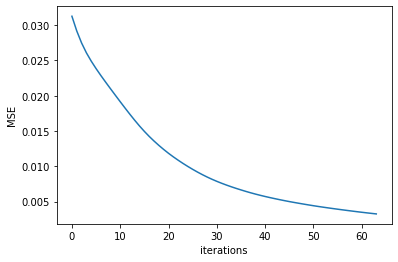

In [107]:
mlp_regressor = MLPRegressor(random_state=1, activation='relu', solver='adam', max_iter=1000, hidden_layer_sizes=(64)).fit(countries_features_train, countries_total_cost_train)
countries_total_cost_test_pred = mlp_regressor.predict(countries_features_test)
print("RMSE of multi-layered perceptron = " , np.sqrt(mean_squared_error(countries_total_cost_test, countries_total_cost_test_pred)))
plt.plot(range(len(mlp_regressor.loss_curve_)), mlp_regressor.loss_curve_)
plt.xlabel('iterations')
plt.ylabel('MSE')
plt.show()

### **Attempt 2: Linear Regression**

linear regression is a linear approach to modeling the relationship between a instances feature vector and their target values. It tries to select the best line that can fit the data points. In case of multi dimensions feature vector, it tres to select the best hyperplane to fit the data points.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Linear_regression.svg/1200px-Linear_regression.svg.png)

Linear regression model follows the following equation:
$$f(x) = \beta_0 + \sum_{j=1}^d\beta_jx_j$$
where:


*   $f(x)$ is the predicted target value of instance $x$ 
*   $\beta s$ are called parameters or coefficients or weights.
*   $x_j$ is the feature $j$ of instance $x$

The goal of linear regression is to learn $\beta s$. The goal of linear regression can be acheived by three ways:
1. **First derivative:** Try to minimize the mean squared error $$MSE = \frac{1}{2n}\sum_{i=1}^n (Y_i - (\beta_0 + \sum_{j=1}^d\beta_jx_{ij}))^2$$
That is $$\frac{\partial MSE}{\partial \beta_j} = 0 ; j = 0:d$$

2. **Matrix Representation:** Let $X$ be an n * (d + 1) matrix where each row starts with a 1 followed by a feature vector. Let $y$ be the target vector of the training set. Let $\beta$ be the vector of weights that we want to reach.
The simple equation to get $\beta$ using matrix $X$ and vector $y$ is:
$$\beta = (X^TX)^{-1}X^Ty$$

3. **Gradient Descent:** Update simultaneously all $\beta_j$ until convergence
$$\beta_j = \beta_j - \alpha\frac{\partial}{\partial \beta_j}MSE$$
where $\alpha$ is a learning rate.




In [108]:
linear_regressor = linear_model.LinearRegression().fit(countries_features_train, countries_total_cost_train)
countries_total_cost_test_pred = linear_regressor.predict(countries_features_test)
print("RMSE of linear regression = " , np.sqrt(mean_squared_error(countries_total_cost_test, countries_total_cost_test_pred)))

RMSE of linear regression =  0.13728826981542241


### **Attempt 3: Random forest Regression**

Random forests or random decision forests are an ensemble learning method for regression. It operates by constructing a multitude of decision trees at training time and outputting the class that is the mean prediction (regression) of the individual trees. 
$$f' = \frac{1}{B}\sum_{b=1}^B f_b(x)$$

![](https://miro.medium.com/max/2612/0*f_qQPFpdofWGLQqc.png)


Random forests correct for decision trees' habit of overfitting to their training set.

Random forests have 2 mean parameters to be set:


*   **n_estimators:** The number of trees in the forest.
*   **max_depth:** The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min samples split (default here is 2).



In [109]:
rf_regressor = RandomForestRegressor(max_depth=10, n_estimators=5,  random_state=0)
rf_regressor.fit(countries_features_train, countries_total_cost_train)
countries_total_cost_test_pred = rf_regressor.predict(countries_features_test)
print("RMSE of random forest regression perceptron = " , np.sqrt(mean_squared_error(countries_total_cost_test, countries_total_cost_test_pred)))

RMSE of random forest regression perceptron =  0.06019355239688291


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


### **Attempt 4: Fully Connected Neural Network**

Neural networks are used to recognize correlations and hidden patterns in raw data. It works as a black box; an input layer gets the data into the “hidden layers” and after that we can see the information provided by the output layer.

![](https://compphysics.github.io/MachineLearning/doc/pub/cnn/html/figslides/nn.jpeg)

We designed a fully connected neural network (FCNN) with input layer where the number of neurons in it equals the number of country features (9). The neural network contains of 5 hidden layers:


1.   1st hidden layers consists of 128 neurons
2.   2nd hidden layers consists of 64 neurons
3.   3rd hidden layers consists of 32 neurons
4.   4th hidden layers consists of 16 neurons
5.   5th hidden layers consists of 8 neurons

Each neuron in the hidden layers and output layer has a bias value that's included during calculating the value of that neuron.

At each level the number of parameters to be optimized follow the following equation:

$$P = I*N + B$$
where:

*   $I$ is the number of input neurons
*   $N$ is the number of neurons in the layer
*   $B$ is the number of biases in the layer

We used relu activation function for all the neurons in the neural network $$f(x) = max(0, x)$$

Backpropagation is used for optimizing the weights and biases values for training (we used **adam** solver for weight optimization which refers to a stochastic gradient-based optimizer).

During the neural network training, sample of the training data is extracted as a validation data to test if the model is learning from the data or not and indication of overfitting of the model.




In [103]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(len(countries_features[0]),)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
  ])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_55 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_56 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_57 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_58 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 9         
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
__________________________________________________

In [104]:
history = model.fit(countries_features_train, countries_total_cost_train, epochs=1000, validation_split = 0.1, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0570,  mse:0.0570,  val_loss:0.1206,  val_mse:0.1206,  
....................................................................................................
Epoch: 100, loss:0.0008,  mse:0.0008,  val_loss:0.0266,  val_mse:0.0266,  
....................................................................................................
Epoch: 200, loss:0.0003,  mse:0.0003,  val_loss:0.0206,  val_mse:0.0206,  
....................................................................................................
Epoch: 300, loss:0.0002,  mse:0.0002,  val_loss:0.0202,  val_mse:0.0202,  
....................................................................................................
Epoch: 400, loss:0.0001,  mse:0.0001,  val_loss:0.0215,  val_mse:0.0215,  
....................................................................................................
Epoch: 500, loss:0.0001,  mse:0.0001,  val_loss:0.0229,  val_mse:0.0229,  
..............................................

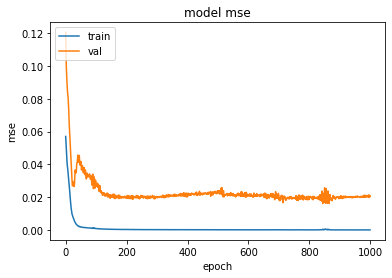

In [105]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [110]:
countries_total_cost_test_pred = model.predict(countries_features_test, verbose=1).flatten()
print("RMSE of neural network= " , np.sqrt(mean_squared_error(countries_total_cost_test, countries_total_cost_test_pred)))

1/1 [==============================] - 0s 979us/step
RMSE of neural network=  0.06867430516315633


# **Conclusion**

After trying the four attempts, the results of there root mean squared error (RMSE) are as follow:


|                                |      RMSE     |
|--------------------------------|:-------------:|
| Multi-Layered Perceptron       |  0.07907      |
| Linear Regression              |  0.1373       |
| Random Forest Regression       |  0.06019      |
| Fully Connected Neural Network |  0.06867      |


As shown, the attempt with best result is given by **Random Forest Regression**. So, we candepend on Random forest Regression for predicting the total cases of Covid-19 for a country in 15/5/2020. These reults depends on the training data that is used for each one of the models. So, with another training data the results may change and another model may be better of Random Forest Regression.

# **References**
[TensorFlow Regression Tutorial](https://www.tensorflow.org/tutorials/keras/regression)

[Scikit-Learn Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

[Scikit-Learn Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

[Scikit-Learn Muilti-Layer Perceptron](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)
